In [1]:
import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf

import datetime
from IPython.display import clear_output

In [2]:
df_companies = pd.read_csv('companies_marketcap_2dec2022.csv',index_col='Rank')
df_companies

,Name,Symbol,marketcap,price (USD),country
Rank,,,,,
1,Apple,AAPL,2351376105472,147.81,United States
2,Saudi Aramco,2222.SR,1938200000000,8.81,Saudi Arabia
3,Microsoft,MSFT,1901039058944,255.02,United States
4,Alphabet (Google),GOOG,1303227793408,100.83,United States
5,Amazon,AMZN,960286031872,94.13,United States
...,...,...,...,...,...
7102,FedNat Holding Company,FNHC,175192,0.01,United States
7103,NewAge,NBEVQ,73406,0.00,United States
7104,Pareteum Corporation,TEUM,14270,0.00,United States


For this analysis, we collect data from 2019-2020 as our in-sample period, 2021-2022 (Nov end 2022) as our out-of-sample period.

In [3]:
companies_list = df_companies['Symbol'].tolist()

start = datetime.date(2019, 1, 1) #year,month,day
end = datetime.date.today()

We start by taking the top 100 companies by market capitalization for our initial analysis, as we clean our data some names might get omitted, so we'll ultimately the top 100 of what's left for our actual strategy.

In [4]:
df_prices = pd.DataFrame()

counter = 0 
counter_lim = 100
for company_name in companies_list:
    
    company_data = yf.download(company_name, start, end, progress=False)
    
    #check if yfinance has data on the company to begin with
    if company_data.empty:
        pass
    #check if company has data for start of 2019 onwards, omit if it does not
    elif company_data.index[0] == pd.Timestamp('2019-01-02'):
        counter += 1
        df_prices = pd.concat([df_prices,company_data[['Close']].rename(columns = {'Close':company_name})], axis=1)
        clear_output(wait=True)
        print('Stock download progress:', str(counter), 'of', str(counter_lim))
    
    if counter == counter_lim:
        break

Stock download progress: 100 of 100


At this stage, we have downloaded the Yahoo Finance data of top 125 companies with data present from Jan 1st 2019. Let's get a feel for the the number of missing values in our dataset:

In [5]:
len(df_prices.index)

1023

In [6]:
df_prices.isnull().sum().describe()

count    100.000000
mean      34.500000
std       11.110556
min       12.000000
25%       32.000000
50%       32.000000
75%       32.000000
max       71.000000
dtype: float64

It seems like most of our data points have 32 null values our of 1018 date entries, while a handful have as much as 71 missing values for the corresponding date entries. To deal with missing values, I first remove the respective rows if majority of the stocks have missing entries for the same date across the board, and then interpolate isolated points. Keeping stocks with too many missing entries will cause major problems in retaining data with the above methods, so I will take the mean of the null values (which should be skewed up above 50 by the outliers) and remove all stocks from the dataframe that have more null values than the mean of the null values summed across each column/for each stock at this stage.

Thus, we will shorten this space further, by checking what the mean number of null values present are and removing all companies with more null values than the mean, so as to preserve large cap companies with the most complete datasets for this period of time.

In [7]:
df_prices[df_prices.isnull().any(axis=1)].isnull().sum(1).tolist()

[84,
 1,
 7,
 11,
 11,
 10,
 6,
 84,
 1,
 10,
 93,
 9,
 1,
 6,
 6,
 15,
 6,
 6,
 1,
 4,
 84,
 1,
 10,
 1,
 4,
 84,
 1,
 84,
 1,
 7,
 10,
 6,
 7,
 6,
 10,
 1,
 84,
 90,
 9,
 1,
 84,
 7,
 12,
 10,
 6,
 6,
 6,
 84,
 6,
 93,
 9,
 1,
 5,
 15,
 6,
 7,
 84,
 1,
 10,
 6,
 4,
 84,
 1,
 84,
 1,
 11,
 11,
 6,
 6,
 6,
 6,
 1,
 4,
 4,
 84,
 94,
 1,
 1,
 84,
 1,
 7,
 11,
 94,
 6,
 6,
 1,
 93,
 15,
 4,
 6,
 6,
 7,
 5,
 84,
 11,
 4,
 84,
 1,
 84,
 7,
 7,
 5,
 10,
 7,
 6,
 6,
 6,
 1,
 4,
 4,
 84,
 84,
 5,
 1,
 1,
 8,
 84,
 1,
 7,
 11,
 11,
 10,
 6,
 84,
 1,
 1,
 6,
 10,
 93,
 9,
 1,
 10,
 6,
 6,
 1,
 5,
 84,
 1,
 10,
 1,
 1,
 84,
 4,
 84,
 1,
 84,
 1,
 11,
 1,
 7,
 10,
 6,
 6,
 6,
 1,
 84]

We see that there's a handful of rows where the majority of the data points are NaNs - we will remove those rows from our dataset.

In [8]:
mean_null_rows = np.ceil(df_prices[df_prices.isnull().any(axis=1)].isnull().sum(1).mean())
temp_df = df_prices[df_prices.isnull().any(axis=1)].isnull().sum(1).to_frame()
row_drop_list = temp_df.loc[temp_df[0]>mean_null_rows].index.to_list()
df_prices = df_prices.drop(row_drop_list, axis=0)

In [9]:
len(df_prices.index)

991

In [10]:
df_prices.isnull().sum().describe()

count    100.000000
mean       7.000000
std       19.042748
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       70.000000
dtype: float64

Most stocks have 0 missing data points now, which is great news for us. A handful of stocks still have upto 71 data points out of 986 date entries - which is just over 7% missing data. Let's take a closer look at them now, to understand how the NaN values are distributed across those columns. Using that understanding, we'll decide whether to drop those columns or interpolate their stock prices.

In [11]:
temp_df = df_prices.isnull().sum().to_frame()
has_missing_vals = temp_df.loc[temp_df[0] > df_prices.isnull().sum().mean()].index
display(len(has_missing_vals))
has_missing_vals

12

Index(['005930.KS', '600519.SS', '1398.HK', '601939.SS', '0941.HK',
       '601288.SS', '300750.SZ', '3690.HK', '601857.SS', '3968.HK',
       '601988.SS', 'CBA.AX'],
      dtype='object')

In [12]:
outlier_stock_names = temp_df.loc[temp_df[0] > df_prices.isnull().sum().mean()].index.tolist()
df_prices[outlier_stock_names][df_prices[outlier_stock_names].isnull().any(axis=1)].head(50)

,005930.KS,600519.SS,1398.HK,601939.SS,0941.HK,601288.SS,300750.SZ,3690.HK,601857.SS,3968.HK,601988.SS,CBA.AX
Date,,,,,,,,,,,,
2019-01-28,45050.0,677.000000,5.95,6.77,82.400002,3.68,76.070000,47.450001,7.27,32.900002,3.61,NaN
2019-02-04,NaN,NaN,5.97,NaN,83.400002,NaN,NaN,54.650002,NaN,33.950001,NaN,70.300003
2019-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.599998
2019-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.599998
2019-02-07,46200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.059998
2019-02-08,44800.0,NaN,5.94,NaN,82.349998,NaN,NaN,57.900002,NaN,33.799999,NaN,74.750000
2019-03-01,NaN,789.299988,6.03,7.34,83.900002,3.85,90.029999,60.000000,7.88,37.250000,3.90,74.349998
2019-04-05,46850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.889999
2019-04-22,45350.0,949.200012,NaN,7.37,NaN,3.78,81.230003,NaN,7.73,NaN,3.93,NaN


In [13]:
df_prices[outlier_stock_names][df_prices[outlier_stock_names].isnull().any(axis=1)].tail(50)

,005930.KS,600519.SS,1398.HK,601939.SS,0941.HK,601288.SS,300750.SZ,3690.HK,601857.SS,3968.HK,601988.SS,CBA.AX
Date,,,,,,,,,,,,
2021-06-14,80500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,80100.0,2105.000000,NaN,6.75,NaN,3.04,529.500000,NaN,5.24,NaN,3.08,98.699997
2021-08-16,NaN,1699.199951,4.40,5.90,51.900002,2.93,477.000000,221.399994,4.60,65.500000,3.03,102.540001
2021-09-20,NaN,NaN,4.21,NaN,47.000000,NaN,NaN,234.600006,NaN,57.500000,NaN,100.809998
2021-09-21,NaN,NaN,4.21,NaN,47.150002,NaN,NaN,230.600006,NaN,57.650002,NaN,100.339996
2021-09-22,NaN,1637.689941,NaN,5.95,NaN,2.95,493.309998,NaN,6.11,NaN,3.05,99.639999
2021-10-01,73200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.080002
2021-10-04,NaN,NaN,4.27,NaN,46.650002,NaN,NaN,236.800003,NaN,59.599998,NaN,105.160004
2021-10-05,72200.0,NaN,4.31,NaN,46.900002,NaN,NaN,233.600006,NaN,58.950001,NaN,105.500000


Clearly, among the stocks with missing values, a significant number of these have missing values on the same few lines. We will remove these rows, likely what's going on is that these stocks belong to the same foreign exchange and don't have data for those reporting days as a standard. Thus, to ensure we build a strategy on the same playing date across exchanges, we will remove these lines as well.

In [14]:
remove_dates = df_prices[outlier_stock_names][df_prices[outlier_stock_names].isnull().any(axis=1)].isnull().sum(axis=1).to_frame()
row_drop_list2 = remove_dates.index.tolist()
df_prices = df_prices.drop(row_drop_list2, axis=0)
len(df_prices.index)

867

In [15]:
df_prices.isnull().sum().describe()

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

Now we have processed all the null data for the top stocks by market cap. We originally started with top 100 stocks with data present from Jan 1st 2019 and 1018 dates' rows with multiple missing entries, and now we have 100 stocks left and 862 dates' rows with no missing entries.

Finally, we store this information into a csv file for future use.

In [16]:
df_prices.to_csv("top100cap_stock_prices.csv", sep=',', index=True)

In [17]:
df_prices = pd.read_csv('top100cap_stock_prices.csv',parse_dates=['Date'],index_col='Date')
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 867 entries, 2019-01-02 to 2022-12-06
Data columns (total 100 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AAPL       867 non-null    float64
 1   MSFT       867 non-null    float64
 2   GOOG       867 non-null    float64
 3   AMZN       867 non-null    float64
 4   BRK-B      867 non-null    float64
 5   TSLA       867 non-null    float64
 6   UNH        867 non-null    float64
 7   JNJ        867 non-null    float64
 8   V          867 non-null    float64
 9   XOM        867 non-null    float64
 10  TSM        867 non-null    float64
 11  NVDA       867 non-null    float64
 12  WMT        867 non-null    float64
 13  JPM        867 non-null    float64
 14  TCEHY      867 non-null    float64
 15  MC.PA      867 non-null    float64
 16  PG         867 non-null    float64
 17  LLY        867 non-null    float64
 18  CVX        867 non-null    float64
 19  MA         867 non-null    flo

In [18]:
dates_list = ['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']

### Correlation Plot of each of the 100 stocks over the first training/pre out-of-sample period (2019-01-01 to 2021-01-01):

In [19]:
correlations = df_prices.loc[dates_list[0]:dates_list[2]].corr()
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)
cax = ax.imshow(correlations)
fig.colorbar(cax)
ticks = np.arange(0,len(df_prices.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df_prices.columns)
ax.set_yticklabels(df_prices.columns)
plt.show()
plt.close()

In [20]:
stock1 = df_prices.columns[0] #ticker for biggest stock by market cap
stock1

'AAPL'

In [21]:
#note our use of 2017-01-01 to 2021-01-01 to find the largest market cap stock for running a pairs-trading strategy
correlations = df_prices.loc[dates_list[0]:dates_list[4]].corr()
corr_s1 = correlations[[stock1]]
stock2 = corr_s1.loc[corr_s1[stock1]>0.8].index.tolist()[1] #find biggest stock with correlation >0.8 to stock1
stock2

'MSFT'

In [22]:
correlations[stock1][stock2] #correlation between AAPL and MSFT

0.9629497287134698

Thus, we chose AAPL and MSFT to be our two large cap stocks to investigate further for a pairs trading strategy.

In [23]:
df_stock1 = df_prices[[stock1]]
df_stock2 = df_prices[[stock2]]
data = pd.merge(df_stock1, df_stock2, on='Date')
data2 = data[dates_list[0]:dates_list[2]]

### Correlation Plot of each of the 100 stocks over out-of-sample period (2021-01-01 to 2022-11-30):

In [24]:
correlations = df_prices.loc[dates_list[2]:].corr()
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)
cax = ax.imshow(correlations)
fig.colorbar(cax)
ticks = np.arange(0,len(df_prices.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df_prices.columns)
ax.set_yticklabels(df_prices.columns)
plt.show()
plt.close()

Notice how in our out-of-sample period, the strong correlations from our in-sample period break down in the above correlation matrix plot (but we don't really have knowledge of that at first when we implement the strategy for an out-of-sample period starting 2021-01-01, this only gets revealed to us in sequentially so it's critical that the strategy is updated to account for increasing/decreasing variability, which in turn affects our model for spread)

In [25]:
correlations[stock1][stock2] #correlation between AAPL and MSFT

0.7124170672309676

In [26]:
correlations2 = df_prices.loc[dates_list[2]:].corr()
corr_s12 = correlations2[[stock1]]
stock22 = corr_s12.loc[corr_s12[stock1]>0.8].index.tolist()[1] #find biggest stock with correlation >0.8 to stock1
stock22

'PG'

Again, we don't know this for out-of-sample period, but the reality is MSFT and AAPL correlation weakens significantly after 2020, from 0.96 to 0.71 Pearson correlation score. In the entire out-of-sample period, turns our Proctor and Gamble have the best correlation to AAPL - but we ignore that because we only have pre out-of-sample period to help us decide which stock is best correlated.

### Price Movements for entire timeframe 2019-01-01 to 2022-11-30

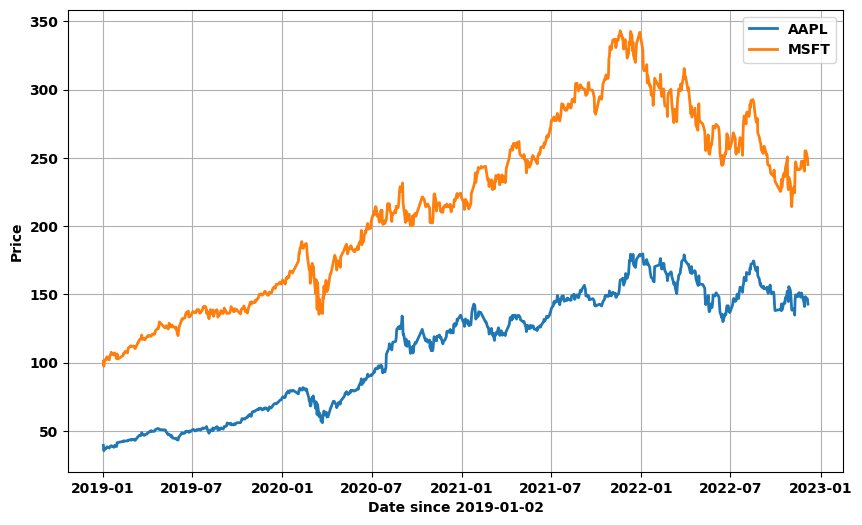

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df_stock1,linewidth=2,label=stock1)
plt.plot(df_stock2,linewidth=2,label=stock2)
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Date since ' + str(data.index[0])[:10])
plt.ylabel('Price')
plt.legend()
plt.show()
plt.close()

### Cumulative Return Plot for entire timeframe (2019-01-01 to 2022-11-30)

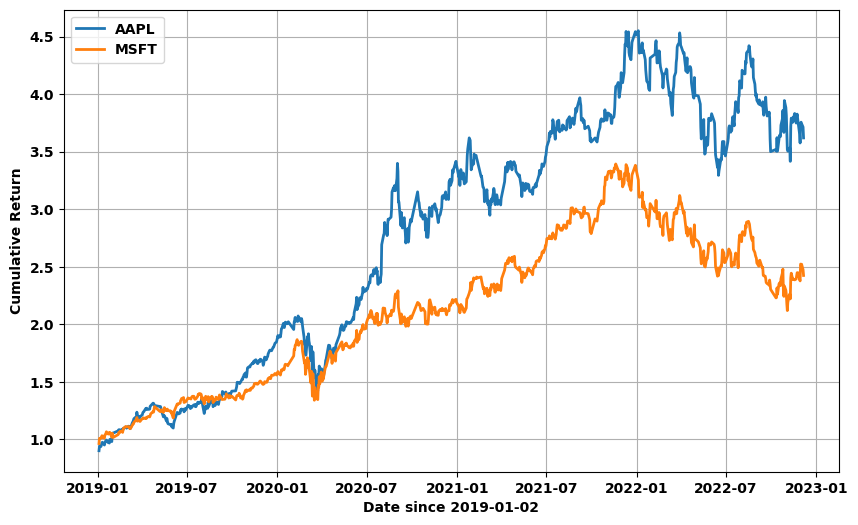

In [28]:
plt.figure(figsize=(10,6))
plt.plot((df_stock1.pct_change()+1).cumprod(),linewidth=2,label=stock1)
plt.plot((df_stock2.pct_change()+1).cumprod(),linewidth=2,label=stock2)
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Date since ' + str(data.index[0])[:10])
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
plt.close()

### OLS Regression Fit for pre out-of-sample period (2019-01-01 to 2021-01-01)

C:\Users\karti\AppData\Local\Temp\ipykernel_8216\1424800350.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p)[:10] for p in data2[::len(data2)//9].index])


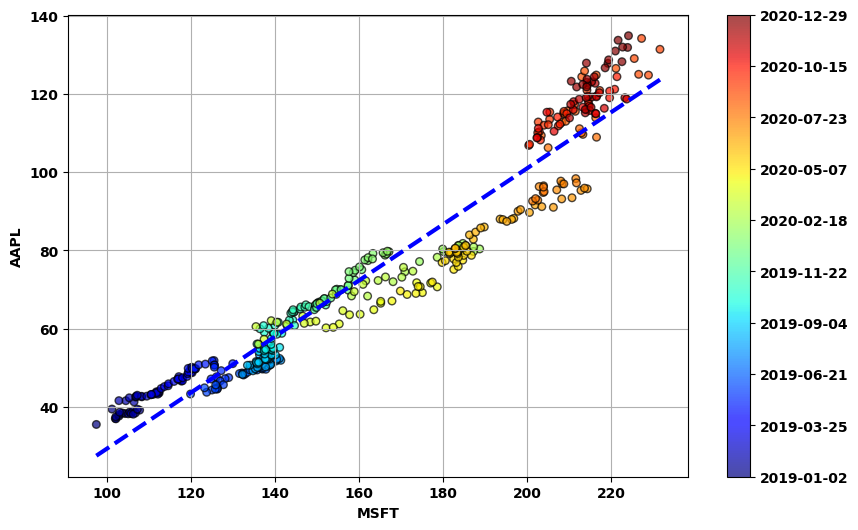

In [29]:
tickers = [stock1, stock2]

x = sm.add_constant(data2[tickers[1]], prepend=False)
ols = sm.OLS(data2[tickers[0]], x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

plt.figure(figsize=(10,6))
colors = np.linspace(0.1, 1, len(data2))
sc = plt.scatter(data2[tickers[1]], data2[tickers[0]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p)[:10] for p in data2[::len(data2)//9].index])
plt.xlabel(tickers[1])
plt.ylabel(tickers[0])
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

Observe here that within the pre out-of-sample period, the data fits a straight line well from 2019 to early-2020, but seems to fit slightly different gradients better with significant changes in gradient in the second half of 2020. To account for the shift in gradients and the variability in stock pricing as a result, I choose a two-year in-sample period to forecast a three-month out-of-sample period, starting from 2019-01-01 to 2021-01-01 for training and 2021-01-01 to 2021-04-01 for out-of-sample. Then, retrain my model every three months, so the next training period will be 2019-04-01 to 2021-04-01, for an out-of-sample period of 2021-04-01 to 2021-07-01, and so on.

To verify this, I rerun a regression fit on AAPL against MSFT on the whole timeframe. This is justified and will not constitute look-ahead bias, because I can observe a clear trend prior to my first out-of-sample period, and every three months, I will retrain my regression model to update my beta coefficient values for the out-of-sample prediction period.

### OLS Regression Fit on entire timeframe

C:\Users\karti\AppData\Local\Temp\ipykernel_8216\3759314460.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p)[:10] for p in data[::len(data)//9].index])


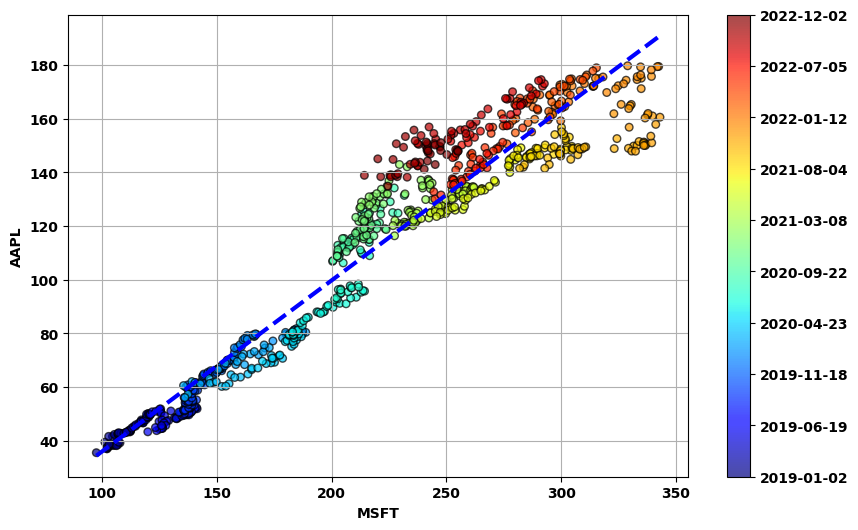

In [30]:
tickers = [stock1, stock2]

x = sm.add_constant(data[tickers[1]], prepend=False)
ols = sm.OLS(data[tickers[0]], x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

plt.figure(figsize=(10,6))
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[1]], data[tickers[0]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p)[:10] for p in data[::len(data)//9].index])
plt.xlabel(tickers[1])
plt.ylabel(tickers[0])
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

Clearly, it appears there's merits to taking a two-year in-sample period to cover variability in trends in this context. The one clear downside of such an approach is that standard deviations of spread can be reduced over a big period if there are long periods of stability/lack of deviation from a straight line trend between both prices. This might result in poor predictions for modelling the spread, which in turns affects a strategy where we book a loss in the market.